In [111]:
%matplotlib inline
from pyns import Neuroscout
from pathlib import Path
import nilearn.plotting as niplt
import nibabel as nib
import pandas as pd
import seaborn as sns
import json
api = Neuroscout()

## Various imports

In [112]:
RESULTS_DIR = Path('/media/hyperdrive/neuroscout-cli/output/')

In [310]:
cqt = json.load(open('models/cqt_rms.json'))
tonal = json.load(open('models/tonal_rms.json'))
mel = json.load(open('models/mel_rms.json'))
mfcc = json.load(open('models/mfcc_rms.json'))

In [311]:
cqt

{'Budapest': {'movie': 'cg4rj'},
 'HealthyBrainNetwork': {'movieDM': 'i7r8m'},
 'SchematicNarrative': {'perception': 'bcmwt'},
 'studyforrest': {'movie': 'ah96f'},
 'Raiders': {'raiders': 'q2ytn'},
 'Life': {'life': 'iawf9'},
 'ParanoiaStory': {'story': 'jkk5a'},
 'Sherlock': {'sherlockPart1': '8syob'},
 'SherlockMerlin': {'MerlinMovie': '7jxpc', 'SherlockMovie': '9hqw6'},
 'LearningTemporalStructure': {'movie': '6u4pc'}}

In [312]:
analyses = {'cqt': cqt['ParanoiaStory']['story'],
            'tonal': tonal['ParanoiaStory']['story'], 
            'mel': mel['ParanoiaStory']['story'],
            'mfcc': mfcc['ParanoiaStory']['story']}

In [313]:
for k, v in analyses.items():
    analyses[k] = api.analyses.get_analysis(v)

Plot for single subject

In [314]:
def _non_zero_mean(img):
    d = img.get_data()
    return d.mean()

In [278]:
rq1 = nib.load(str(list((RESULTS_DIR / analyses['tonal'].hash_id / 'fitlins' / 'sub-sid000007').glob('*rSq*'))[0]))
rq2 = nib.load(str(list((RESULTS_DIR / analyses['cqt'].hash_id / 'fitlins' / 'sub-sid000007').glob('*rSq*'))[0]))
rq3 = nib.load(str(list((RESULTS_DIR / analyses['tonal'].hash_id / 'fitlins' / 'sub-sid000007').glob('*rSq*'))[0]))
rq4 = nib.load(str(list((RESULTS_DIR / analyses['cqt'].hash_id / 'fitlins' / 'sub-sid000007').glob('*rSq*'))[0]))

IndexError: list index out of range

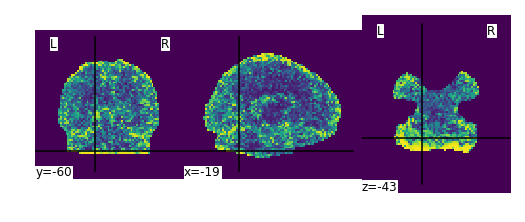

In [279]:
niplt.plot_img(rq1)

In [280]:
_non_zero_mean(rq1)

/home/roberta/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  


0.09318832305343232

Compute R-squared for all subjects and all analyses

In [315]:
def _get_all_model_maps(analysis, key='rSquare'):
    rsqs = []
    for subject in (RESULTS_DIR / analysis.hash_id / 'fitlins').glob('sub*'):
        rsqs.append(_non_zero_mean(nib.load(str(list(subject.glob(f"*{key}*"))[0]))))
    return rsqs

## Look at overall R-squared for each model

In [316]:
rsquared_all = {}
for n, an in analyses.items():
    rsquared_all[n] = _get_all_model_maps(an)

/home/roberta/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  


In [317]:
rsquared_all = pd.DataFrame(rsquared_all)

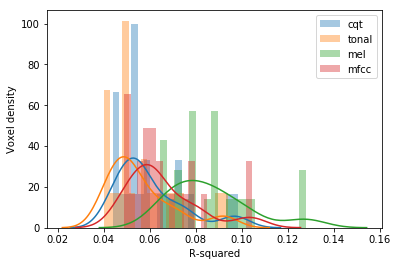

In [318]:
from matplotlib import pyplot as plt
for k,v in rsquared_all.items():
    sns.distplot(v, label=k, bins=20)
plt.xlabel('R-squared')
plt.ylabel('Voxel density')
plt.legend()
plt.show()

### Compute across-subject average

In [319]:
def _get_maps(analysis, key='rSquare'):
    rsqs = []
    for subject in (RESULTS_DIR / analysis.hash_id / 'fitlins').glob('sub*'):
        rsqs.append(nib.load(str(list(subject.glob(f"*{key}*"))[0])))
        
    return rsqs

In [320]:
rsquared_all = {}
for n, an in analyses.items():
    rsquared_all[n] = _get_maps(an)

In [321]:
cqt4d = nib.concat_images(rsquared_all['cqt'], axis=-1)
tonal4d = nib.concat_images(rsquared_all['tonal'], axis=-1)
mfcc4d = nib.concat_images(rsquared_all['mfcc'], axis=-1)
mel4d = nib.concat_images(rsquared_all['mel'], axis=-1)

In [322]:
from nilearn.image import mean_img, math_img

In [323]:
mean_cqt = mean_img(cqt4d)
mean_tonal = mean_img(tonal4d)
mean_mel = mean_img(mel4d)
mean_mfcc = mean_img(mfcc4d)

## Compare R-squared for each model against average of others

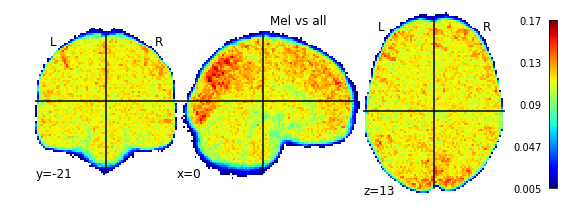

In [324]:
niplt.plot_img(math_img("img4 - (img1 + img2 + img3) / 3",
...                     img1=mean_tonal, 
                        img2=mean_cqt, 
                        img3=mean_mfcc, 
                        img4=mean_mel), 
               cmap='jet', colorbar=True, threshold=.005)
plt.suptitle('Mel vs all')
plt.show()

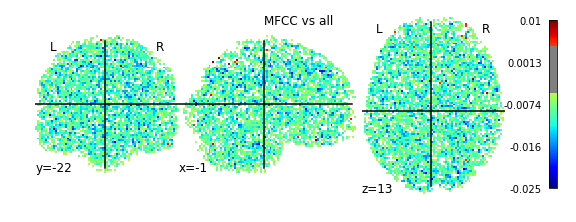

In [325]:
niplt.plot_img(math_img("img4 - (img1 + img2 + img3) / 3",
                        img1=mean_tonal, 
                        img2=mean_cqt, 
                        img4=mean_mfcc, 
                        img3=mean_mel), 
               cmap='jet', colorbar=True, threshold=.005)
plt.suptitle('MFCC vs all')
plt.show()

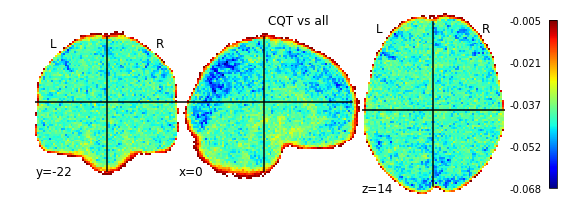

In [326]:
niplt.plot_img(math_img("img4 - (img1 + img2 + img3) / 3",
...                     img1=mean_tonal, 
                        img4=mean_cqt, 
                        img3=mean_mfcc, 
                        img2=mean_mel), 
               cmap='jet', colorbar=True, threshold=.005)
plt.suptitle('CQT vs all')
plt.show()

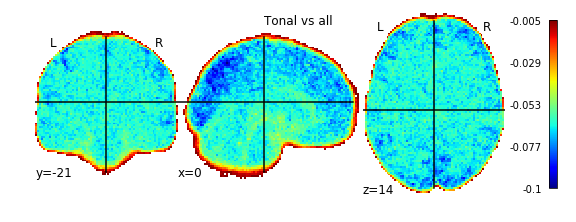

In [327]:
niplt.plot_img(math_img("img4 - (img1 + img2 + img3) / 3",
...                     img4=mean_tonal, 
                        img1=mean_cqt, 
                        img3=mean_mfcc, 
                        img2=mean_mel), 
               cmap='jet', colorbar=True, threshold=.005)
plt.suptitle('Tonal vs all')
plt.show()

## Plot flattened r-squared array by voxel as heatmap

In [294]:
flat_tonal = mean_tonal.dataobj.flatten()
flat_mel = mean_mel.dataobj.flatten()
flat_cqt = mean_cqt.dataobj.flatten()
flat_mfcc = mean_mfcc.dataobj.flatten()

In [295]:
conc = np.vstack([flat_tonal, flat_cqt, flat_mel, flat_mfcc])
conc = conc[:, conc.mean(axis=0) > 0.05]

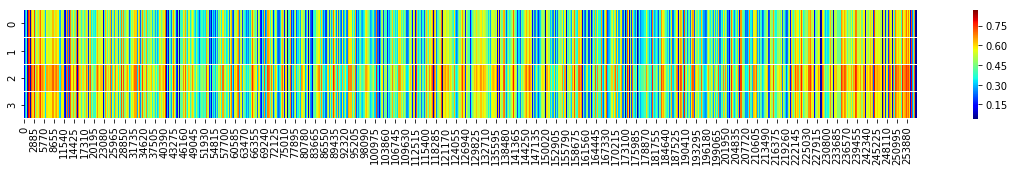

In [296]:
fig, ax = plt.subplots(figsize=(20,2))
sns.heatmap(conc, cmap='jet')
plt.show()

## Visualize where each image is best

In [297]:
best_mfcc = ((mean_mfcc.dataobj > mean_cqt.dataobj) & 
            (mean_mfcc.dataobj > mean_tonal.dataobj) &
            (mean_mfcc.dataobj > mean_mel.dataobj)).astype(int)

In [298]:
best_cqt = ((mean_cqt.dataobj > mean_mel.dataobj) & 
            (mean_cqt.dataobj > mean_mfcc.dataobj) &
            (mean_cqt.dataobj > mean_tonal.dataobj)).astype(int)

In [299]:
best_mel = ((mean_mel.dataobj > mean_cqt.dataobj) & 
            (mean_mel.dataobj > mean_mfcc.dataobj) &
            (mean_mel.dataobj > mean_tonal.dataobj)).astype(int)

In [300]:
best_tonal = ((mean_tonal.dataobj > mean_cqt.dataobj) & 
              (mean_tonal.dataobj > mean_mfcc.dataobj) &
              (mean_tonal.dataobj > mean_mel.dataobj)).astype(int)

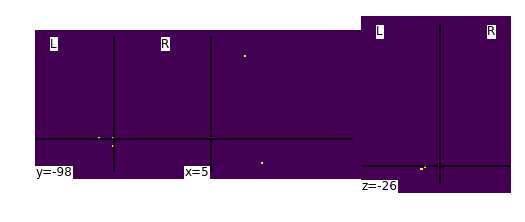

In [301]:
niplt.plot_img(nib.Nifti1Image(best_mfcc, affine=mean_tonal.affine))
plt.show()

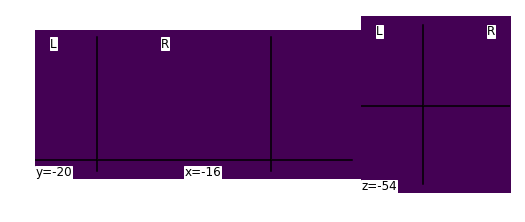

In [302]:
niplt.plot_img(nib.Nifti1Image(best_tonal, affine=mean_tonal.affine))
plt.show()

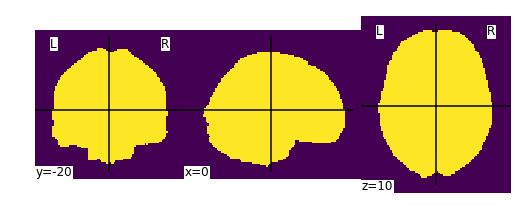

In [303]:
niplt.plot_img(nib.Nifti1Image(best_mel, affine=mean_mel.affine))
plt.show()

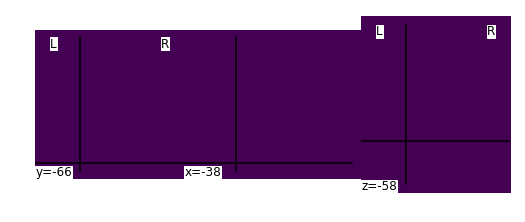

In [304]:
niplt.plot_img(nib.Nifti1Image(best_cqt, affine=mean_cqt.affine))
plt.show()

## Pairwise comparison of the maps

In [309]:
# Change colormap limits

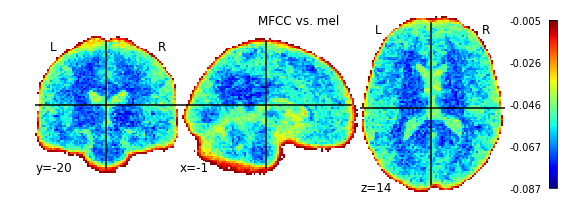

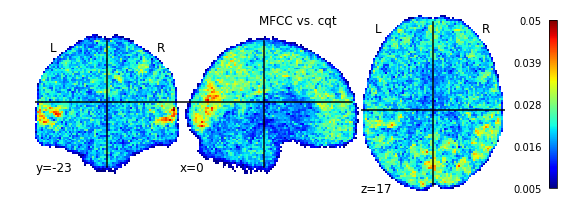

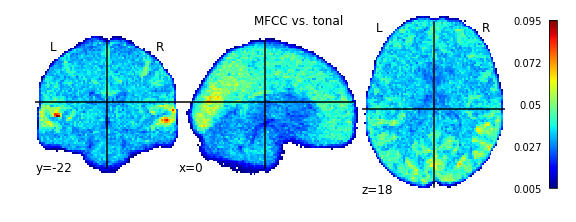

In [305]:
names = ['mel', 'cqt', 'tonal']
for idx, img in enumerate([mean_mel, mean_cqt, mean_tonal]):
    niplt.plot_img(math_img("img1-img2",
                  img1=mean_mfcc, img2=img), 
                  cmap='jet', colorbar=True, 
                  threshold=.005)
    plt.suptitle(f'MFCC vs. {names[idx]}')
plt.show()

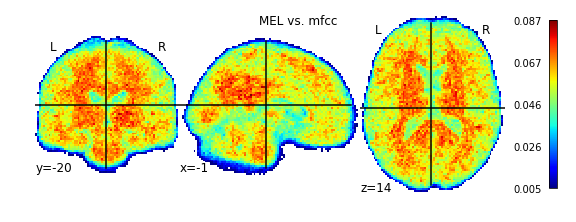

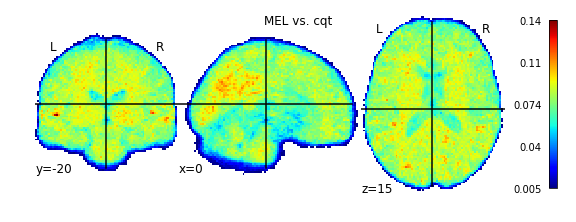

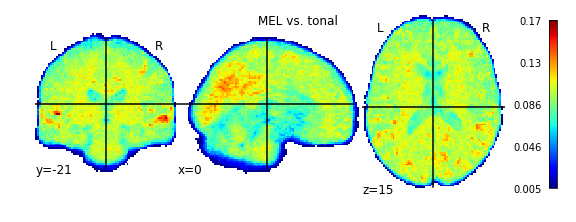

In [306]:
names = ['mfcc', 'cqt', 'tonal']
for idx, img in enumerate([mean_mfcc, mean_cqt, mean_tonal]):
    niplt.plot_img(math_img("img1-img2",
                  img1=mean_mel, img2=img), 
                  cmap='jet', colorbar=True, 
                  threshold=.005)
    plt.suptitle(f'MEL vs. {names[idx]}')
plt.show()

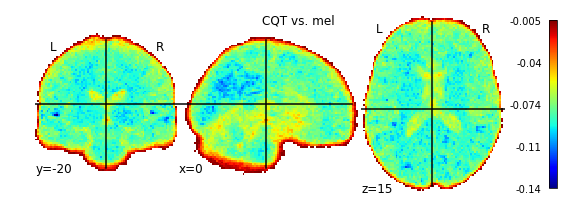

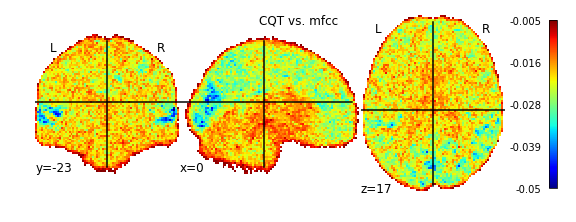

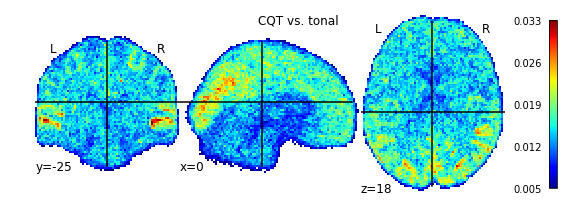

In [307]:
names = ['mel', 'mfcc', 'tonal']
for idx, img in enumerate([mean_mel, mean_mfcc, mean_tonal]):
    niplt.plot_img(math_img("img1-img2",
                  img1=mean_cqt, img2=img), 
                  cmap='jet', colorbar=True, 
                  threshold=.005)
    plt.suptitle(f'CQT vs. {names[idx]}')
plt.show()

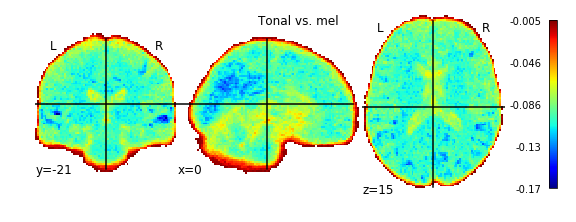

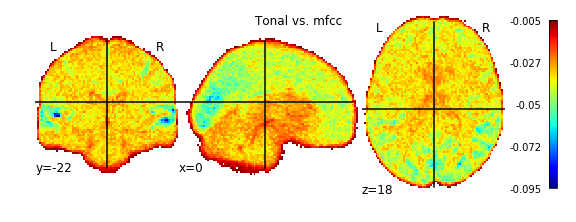

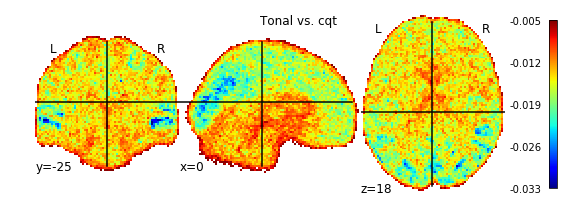

In [308]:
names = ['mel', 'mfcc', 'cqt']
for idx, img in enumerate([mean_mel, mean_mfcc, mean_cqt]):
    niplt.plot_img(math_img("img1-img2",
                  img1=mean_tonal, img2=img), 
                  cmap='jet', colorbar=True, 
                  threshold=.005)
    plt.suptitle(f'Tonal vs. {names[idx]}')
plt.show()